In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# key directories
work = '/work/08811/aew492/ls6/small-scale_cross-corrs'
scratch = '/scratch/08811/aew492/small-scale_cross-corrs'

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from colossus.cosmology import cosmology
import illustris_python as il
import Corrfunc
from Corrfunc.theory.xi import xi
import astropy.units as u
import os
import sys
sys.path.insert(0, work)
import corrfunc_ls
from illustris_sim import IllustrisSim
from illustris_xi import compute_xi_auto_illustris
import tools

#### initialize TNG simulation

In [4]:
z = 0.
sim = IllustrisSim('TNG300-3')
sim.set_snapshot(redshift=z)

### load subhalos

In [5]:
fields = ['SubhaloFlag','SubhaloPos','SubhaloMass','SubhaloMassType', 'SubhaloLenType']
subhalos = il.groupcat.loadSubhalos(sim.basepath, sim.snapshot, fields=fields)
print(f"loaded {subhalos['count']} subhalos")

loaded 391144 subhalos


In [6]:
# how many subhalos are flagged as non-cosmological origin?
frac_flagged = (subhalos['count']-np.sum(subhalos['SubhaloFlag']))/subhalos['count']
print(f"{frac_flagged*100:.2f}% of subhalos got flagged as non-cosmological in origin")

0.09% of subhalos got flagged as non-cosmological in origin


In [7]:
# remove flagged subhalos, and give proper units to position and mass
nsubhalos = np.sum(subhalos['SubhaloFlag'])
# number of each particle type in each subhalo:
len_types = subhalos['SubhaloLenType'][subhalos['SubhaloFlag']]
# (x,y,z) coordinate of each subhalo:
subhalo_pos = (subhalos['SubhaloPos'][subhalos['SubhaloFlag']] * u.kpc).to(u.Mpc)
# total mass of each subhalo:
total_mass = subhalos['SubhaloMass'][subhalos['SubhaloFlag']] * 1e10 * u.M_sun
# total mass of each particle type in each subhalo:
mass_types = subhalos['SubhaloMassType'][subhalos['SubhaloFlag']] * 1e10 * u.Msun

In [8]:
# how many subhalos have stars?
nwithstars = np.sum(mass_types[:,4]>0.)
print(f"{nwithstars} subhalos ({100*nwithstars/subhalos['count']:.2f}%) have stars")

57374 subhalos (14.67%) have stars


Okay so the vast majority of subhalos don't actually have any star particles!!! Remove these.

Right now we're defining a "galaxy" as any subhalo with stars.

In [10]:
# get only the subhalos with non-zero star mass
gal_idx = np.where(mass_types[:,4].value>0.)
gal_pos = subhalo_pos[gal_idx]
gal_mass = total_mass[gal_idx]
gal_mass_types = mass_types[gal_idx]
gal_len_types = len_types[gal_idx]

In [11]:
# particle types
parttyps = ['gas', 'dm', 'stars']
partidx = [0, 1, 4]

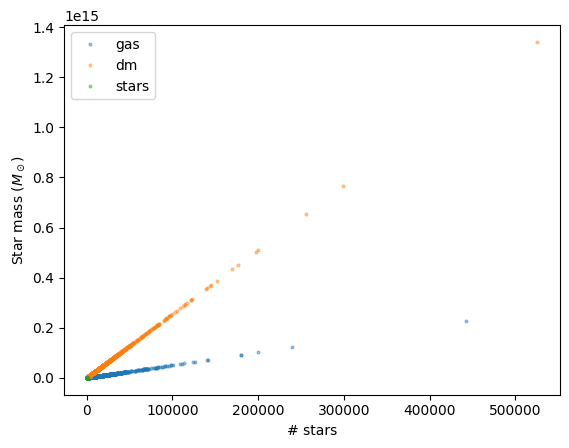

In [12]:
# check out the relation between total star mass and number of stars
fig, ax = plt.subplots()
cs = ['C0', 'C1', 'C2']
for i, idx in enumerate(partidx):
    ax.plot(gal_len_types[:,i], gal_mass_types[:,i].value, marker='.', ms=4, alpha=0.4, color=cs[i], ls='None',
           label=parttyps[i])
ax.set_xlabel('# stars')
ax.set_ylabel(r'Star mass ($M_\odot$)')
ax.legend()

--> Very clear linear relationship between number of stars and star/gas/DM mass.